# Qwen-2.5-7B-Instruct - Cross Lingual Topic Modeling - Notebook 1 - Language Detection & Translation
* Notebook by Adam Lang
* Date: 2/6/2025


# Overview of this notebook
1. Data Analysis and Wrangling
2. Language Detection & Translation
3. Embeddings creation and export to parquet file

Note: Originally the topic modeling was going to be performed in this notebook but due to the fact that I used the "fireducks" library it isnt compatibile with BERTopic and Qwen-2.5 LLM. So the topic modeling is in another notebook.

# Background
* 1. Topic modeling is a very common technique used for extracting meaningful insights and modeling data in any industry or domain.

* 2. Cross-lingual topic modeling is a common multi-step NLP problem when handling multilingual data.
    * Currently the process of working with multilingual data may include the following:
         * 1) Language detection → 
         * 2) Language Translation → 
         * 3) Topic modeling (e.g. BERTopic) → 
         * 4) Using an LLM to transform topics into “more interpretable” terminology → 
         * 5) Creating Data Visualizations to present the Topics to Customers

* However, I have developed a technique that leverages various transformer models and a multilingual open source LLM and multilingual embedding model to perform more robust Topic Modeling.

* While this process still involves language detection and translation as a pre-processing step, we can leverage the LLM as a checks and balances for the preprocessing language detection and translation tasks.

# Workflow
1. Topic Modeling
    * We will perform topic modeling using BERTopic and a multilingual LLM as well as extracting keywords using KeyBERT and also MMR (maximal marginal relevance).

2. Data Visualization
    * We will experiment with some robust data visualization techniques. 



# Introduction
* Usually, the standard workflow for BERTopic when Topic Modeling is:

1. Embedding your documents
2. Reducing the dimensionality of embeddings (e.g. UMAP)
3. Cluster reduced embeddings (e.g. HDBSCAN)
4. Tokenize documents per cluster
5. Extract best-representing words per cluster


# Reasoning for using LLMs
* While BERTopic and other related models are great for easy analysis and extraction of topics, they often are **"not interpretable" and require more human interaction to make them interpretable.**
* Quite often BERTopic will give us an output topic such as: "car-car-store"
    * We could assume this topic is about cars and going to the store but it is very OPEN to interpretation.
    * This is where an LLM like LLAMA or Qwen-2.5 can help us produce more interpretable topic names with keywords to better represent the underlying clusters of data.
* In particular, I will leverage an open-source LLM called Qwen-2.
    * One of Qwen-2's standout features is its **multilingual capabilities**.
    * **Thus we can use this model for cross-lingual topic modeling taking advantage of its robust abilities to handle multi-lingual and cross-lingual detection and translation.**
    * Qwen-2 has been trained on data spanning an **impressive 27 additional languages**.
    * This multilingual training regimen includes languages from diverse regions such as Western Europe, Eastern and Central Europe, the Middle East , Eastern Asia and Southern Asia.
    * The main reason we are going to use Qwen-2 is its performance on the MMLU which as a multi-lingual benchmark, it outperforms Llama-3 and Mistral among others in tasks such as the "Needle in a Haystack Problem."
 
# Multilingual Embeddings
* I am going to use the LLM for cross-lingual topic modeling, thus as part of the pipeline I need to use embeddings.
* You can use ANY embedding model that you want to, here we will use a `SentenceTransformer` model implementation.
* However, because we are dealing with multilingual text, I am going to use a multilingual embedding model that has performed well on text clustering and classification tasks which is what we are trying to do.
 
* Embedding Model I am using: `BAAI/bge-m3`
* Model card: https://huggingface.co/BAAI/bge-m3
* Reasons for using this model:
1) Handles long context windows up to 8192 tokens.
2) Multilingual support
3) Is able to handle 3 common retrieval functionalities of embedding models:
    * dense retrieval
    * multi-vector retrieval
    * sparse retrieval

* Future Models to test against this model:
  * 1) `jinaai/jina-embeddings-v3`
    2) `Snowflake/snowflake-arctic-embed-m`

# Dependencies
* These are the main dependencies for topic modeling.

1. `bertopic`
    * for topic modeling

2. `accelerate`
    * huggingface library for speeding up and optimizing run-time for LLMs and transformers.

3. `bitsandbytes`
    * Used for quantization of embeddings and LLMs

4. `xformers`
    * aims to improve the efficiency and memory usage of Transformers, making it possible to train larger models and handle longer sequences of data.

5. `adjustText`
    * A library to help you adjust text positions on matplotlib plots to remove or minimize overlaps with each other and data points

# Code Needed to Work with AWS SageMaker

In [1]:
%%capture 
!pip install fireducks

In [2]:
%%capture 
!pip install einops

In [3]:
%%capture 
!pip install --upgrade pandas fsspec # sagemaker dependency

In [4]:
%%capture 
!pip install seaborn
!pip install s3fs #sagemaker dependency

In [5]:
%%capture  
## upgrade accelerate to use device_map 
!pip install --upgrade accelerate ## this is for compatability with `bitsandbytes` 



In [6]:
## check accelerate version after upgrade
import accelerate
print(f"Accelerate version: {accelerate.__version__}") 


Accelerate version: 1.3.0


## Main Dependencies for this project

In [7]:
%%capture
!pip install bertopic datasets bitsandbytes xformers adjustText # make sure to install ALL


In [8]:
%%capture 
## upgrade torchvision
!pip install --upgrade torchvision # if you need to upgrade torchvision run this line
!pip install --upgrade torch #upgrade torch version



**Note: You will have to restart the kernel after running cells above, then proceed below.**

In [1]:
# check versions of torch available
import torch
import torchvision 

# print versions
print(f"PyTorch version: {torch.__version__}") 
print(f"Torchvision version: {torchvision.__version__}")

PyTorch version: 2.6.0+cu124
Torchvision version: 0.21.0+cu124


## Check if GPU is available

In [2]:
# check if GPU is available 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 
print(f"Using device: {device}")

# set device for PyTorch operations
if device.type == "cuda":
    torch.cuda.set_device(0) # you can use a different device ID if you have multiple GPUs running


Using device: cuda


# Install Standard Data Science Dependencies

In [3]:
## standard Data Science imports
#%load_ext fireducks.pandas
import pandas as pd
## using fireducks explicit
#import fireducks.pandas as pd
import numpy as np

## plotting
import matplotlib.pyplot as plt
import matplotlib as mpl
from IPython.display import HTML
import seaborn as sns

## other tools
#import response_compare
import re
import functools
from copy import deepcopy
#import chardet
import html #for non ascii detection

## transformers and huggingface
import transformers
#from sentence_transformers import SentenceTransformer, util
import torch
import torchvision ## to use Qwen
import huggingface_hub

## tqdm and pandas
from tqdm.auto import tqdm
tqdm.pandas(leave=False)
#from hashlib import sha256


# Load Data from AWS S3 bucket
* Load both files from S3 bucket to SageMaker

In [ ]:
import boto3
import pandas as pd
from sagemaker import get_execution_role

# Create S3 client
conn = boto3.client('s3')

# S3 bucket name
bucket = '<name of your bucket>'

# Folder path in the S3 bucket
folder_path = ',name_of_path/>'

# CSV file names
file1 = 'file_1.csv'
file2 = 'file_2.csv'  

# Construct the full S3 URIs
data_location1 = f's3://{bucket}/{folder_path}{file1}'
data_location2 = f's3://{bucket}/{folder_path}{file2}'

# Function to load CSV and handle errors
def load_csv_from_s3(data_location):
    try:
        df = pd.read_csv(data_location)
        print(f"Successfully loaded: {data_location}")
        return df
    except Exception as e:
        print(f"An error occurred while loading {data_location}: {e}")
        return None

# Load the DataFrames
df_awards = load_csv_from_s3(data_location1)
df_people = load_csv_from_s3(data_location2)

# Print the heads of the DataFrames if they were successfully loaded
if df_awards is not None:
    print("\nFirst 5 rows of df_1:")
    print(df_awards.head())

if df_people is not None:
    print("\nFirst 5 rows of df_2:")
    print(df_people.head())

# If there were errors, list the contents of the folder
if df_1 is None or df_2 is None:
    print("\nListing contents of the S3 folder:")
    response = conn.list_objects_v2(Bucket=bucket, Prefix=folder_path)
    
    if 'Contents' in response:
        for obj in response['Contents']:
            print(obj['Key'])
    else:
        print("No files found in the specified S3 location.")

# Local Data Upload if not using S3 on AWS

In [4]:
## awards.csv
df_awards = pd.read_csv('awards.csv')
df_awards.head()

,rec_id,nom_id,award_id,ah_id,link_id,group_id,award_private,product_id,award_type,award_reason,title,message,award_date,value,remaining_value
0,8233964,8234230,183347810,180686706,NaN,155345180,0,620,Applaud 2,Make an Impact,Delivering Solid presales support,Kam Wei has been instrumental in helping to cl...,2025-01-01,115.0,115.0
1,27259573,8234230,183349709,180686745,NaN,155346385,0,620,Applaud 2,Lead with Innovation,Strong leader that also contributes in field,Sid is a rare Player-Coach that inspires his c...,2025-01-01,115.0,115.0
2,8234900,8234230,183346874,180686686,NaN,155344570,0,620,Applaud 2,Take Ownership,Executing with excellence,"Myung Soo rejoined Qlik in August 2024, but qu...",2025-01-01,115.0,115.0
3,17519186,8234161,180137859,180686680,NaN,152736571,0,620,Applaud 2,Take Ownership,APAC Presales Superstar for November,"Congrats, Sean!",2025-01-01,110.5,110.5
4,9943897,8234230,183351071,180686682,NaN,155347328,0,620,Applaud 2,Make an Impact,Awesome AE that always delivers,Thank you Jason for being persistent and consi...,2025-01-01,115.0,115.0


In [5]:
## people.csv
df_people = pd.read_csv('people.csv')
df_people.head()

,id,uid,is_manager,manager_id,client_id,hire_date,turnover_date,creation_date,country,department,...,customrole_5,performance_rating,performance_rating_id,potential_rating,potential_rating_id,is_familiar,email,cost_centre_id,cost_centre,modified_date
0,14397179,E07392,ic,16702539,480,1/4/21,5/15/22,1/7/21,SPAIN,2000 OpCo Support,...,NaN,NaN,NaN,NaN,NaN,1,grh@qlik.com,2000,2000 OpCo Support,None
1,13557835,E07225,ic,13887955,480,8/16/20,12/3/21,8/17/20,INDIA,2000 OpCo Support,...,NaN,NaN,NaN,NaN,NaN,1,geu@qlik.com,2000,2000 OpCo Support,None
2,16140437,E07709,ic,8235160,480,7/5/21,10/2/24,7/7/21,INDIA,2000 OpCo Support,...,NaN,NaN,NaN,NaN,NaN,1,hpc@qlik.com,2000,2000 OpCo Support,10/2/24
3,16702539,E07732,manager,27258792,480,8/23/21,None,8/25/21,SWITZERLAND,2000 OpCo Support,...,NaN,NaN,NaN,NaN,NaN,1,hqi@qlik.com,2000,2000 OpCo Support,None
4,21699242,E08491,ic,8233208,480,6/6/22,8/21/22,6/8/22,UNITED STATES,1803 Corp Social Responsibilit,...,NaN,NaN,NaN,NaN,NaN,1,kqb@qlik.com,1803,1803 Corp Social Responsi,None


# Exploratory Data Analysis

## Awards data EDA

In [6]:
## info -awards.csv
df_awards.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85156 entries, 0 to 85155
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   rec_id           85156 non-null  int64  
 1   nom_id           85156 non-null  int64  
 2   award_id         85156 non-null  int64  
 3   ah_id            85156 non-null  int64  
 4   link_id          30115 non-null  float64
 5   group_id         85156 non-null  int64  
 6   award_private    85156 non-null  int64  
 7   product_id       85156 non-null  int64  
 8   award_type       85156 non-null  object 
 9   award_reason     85156 non-null  object 
 10  title            78110 non-null  object 
 11  message          78110 non-null  object 
 12  award_date       85156 non-null  object 
 13  value            85156 non-null  float64
 14  remaining_value  85156 non-null  float64
dtypes: float64(3), int64(7), object(5)
memory usage: 9.7+ MB


In [7]:
## awards.csv columns
df_awards.columns

Index(['rec_id', 'nom_id', 'award_id', 'ah_id', 'link_id', 'group_id',
       'award_private', 'product_id', 'award_type', 'award_reason', 'title',
       'message', 'award_date', 'value', 'remaining_value'],
      dtype='object')

In [8]:
## len of df_awards
len(df_awards)

85156

In [9]:
## check nulls
award_null_counts = df_awards.isnull().sum().sort_values(ascending=False)
award_null_counts

link_id            55041
title               7046
message             7046
rec_id                 0
nom_id                 0
award_id               0
ah_id                  0
group_id               0
award_private          0
product_id             0
award_type             0
award_reason           0
award_date             0
value                  0
remaining_value        0
dtype: int64

In [10]:
award_null_counts.sum()

69133

Summary
* It appears that we have 7,046 null values in the `message` column. We will look closer at this issue before we perform any modeling.
* It is very likely they are actual null values. If they are null then we will impute them with the string "no recognition message".
* However, it is also possible some of the nulls can be unicode characters (non-ascii) if they are chinese or another language with unicode characters so we will look for those as well. 

In [11]:
%%time
# Filter for rows where 'message' is null
null_messages = df_awards[df_awards['message'].isnull()]

# Group by 'award_reason' and 'award_type' for rows with null messages
grouped = null_messages.groupby(['award_reason', 'award_type'])

# Get the count of null messages for each group
result = grouped.size().reset_index(name='null_message_count')

# Sort the result by the count of null messages in descending order
result_sorted = result.sort_values('null_message_count', ascending=False)

# Display the result
print(result_sorted)

# If you want to see more details, you can also include additional statistics
# For example, to see the total count of awards for each group (including non-null messages):
total_count = df_awards.groupby(['award_reason', 'award_type']).size().reset_index(name='total_count')
result_with_total = result.merge(total_count, on=['award_reason', 'award_type'])
result_with_total['percentage_null'] = (result_with_total['null_message_count'] / result_with_total['total_count']) * 100

print("\nDetailed Results:")
print(result_with_total.sort_values('null_message_count', ascending=False))

   award_reason               award_type  null_message_count
0           YOS        1 Year of Service                2670
5           YOS       3 Years of Service                2065
9           YOS       5 Years of Service                1440
1           YOS      10 Years of Service                 619
2           YOS      15 Years of Service                 176
3           YOS      20 Years of Service                  25
6           YOS  3 Years of Service (NP)                  16
10          YOS  5 Years of Service (NP)                  13
4           YOS      25 Years of Service                  12
7           YOS      30 Years of Service                   8
8           YOS      35 Years of Service                   2

Detailed Results:
   award_reason               award_type  null_message_count  total_count  \
0           YOS        1 Year of Service                2670         2670   
5           YOS       3 Years of Service                2065         2065   
9           YOS   

In [12]:
## total null?
result_with_total['null_message_count'].sum()

7046

Summary
* These are all of the null values.
* After talking to Isha and People Analytics we will drop all YOS award types.

/usr/local/lib/python3.10/dist-packages/fireducks/pandas/generic.py:779: UserWarning: df2 = df1.copy(deep=False) might not work, when changes made in the data values of 'df2' is expected to be reflected in 'df1'. REF: https://fireducks-dev.github.io/docs/user-guide/04-compatibility/#copydeep--false
  warnings.warn(


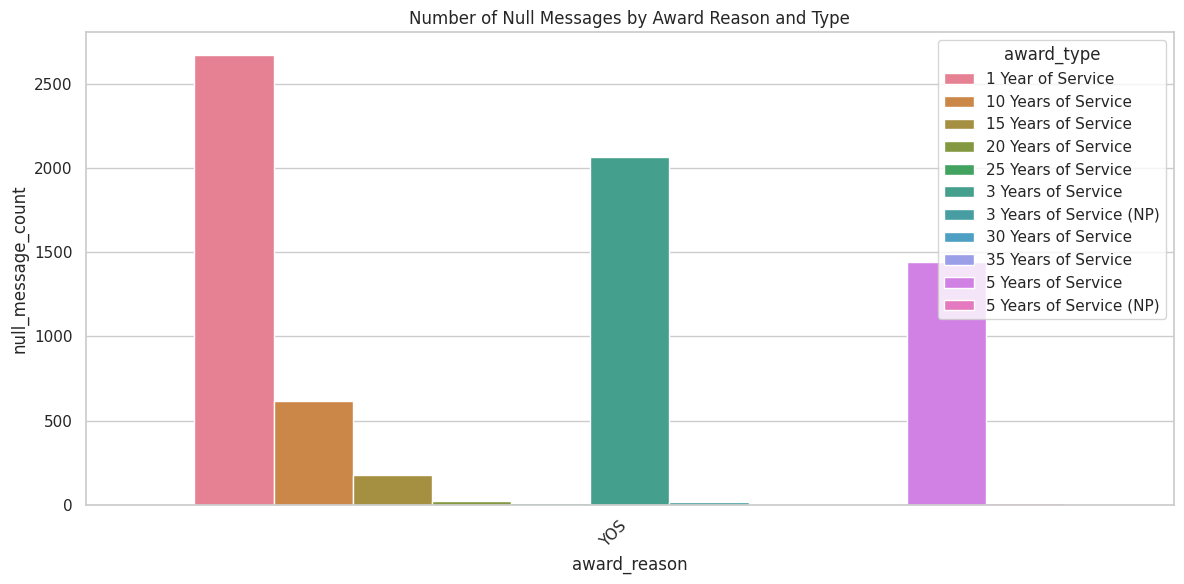

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# Set the style for seaborn plots
sns.set(style="whitegrid")

# Bar Plot
plt.figure(figsize=(12, 6))
sns.barplot(x='award_reason', y='null_message_count', hue='award_type', data=result_with_total)
plt.title('Number of Null Messages by Award Reason and Type')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show();

## People Data EDA
* Note: The purpose of this "metadata" is so we could link topics/keywords by:
1. department
2. job_title
3. job_category
4. position_title
5. country
...etc..

So we won't use it for topic modeling but we may need to merge/join it to the final data if we need to do this analysis.

In [14]:
## info
df_people.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7594 entries, 0 to 7593
Data columns (total 57 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      7594 non-null   int64  
 1   uid                     7594 non-null   object 
 2   is_manager              7594 non-null   object 
 3   manager_id              7594 non-null   int64  
 4   client_id               7594 non-null   int64  
 5   hire_date               7594 non-null   object 
 6   turnover_date           4408 non-null   object 
 7   creation_date           7594 non-null   object 
 8   country                 7594 non-null   object 
 9   department              7594 non-null   object 
 10  language                7594 non-null   object 
 11  user_def1               7594 non-null   object 
 12  user_def2               10 non-null     object 
 13  user_def3               6926 non-null   object 
 14  user_def4               0 non-null      

In [15]:
## cols
df_people.columns

Index(['id', 'uid', 'is_manager', 'manager_id', 'client_id', 'hire_date',
       'turnover_date', 'creation_date', 'country', 'department', 'language',
       'user_def1', 'user_def2', 'user_def3', 'user_def4', 'employmenttype_id',
       'employmenttype_title', 'is_fulltime', 'job_id', 'job_title',
       'job_category', 'position_id', 'position_title', 'function_id',
       'function_title', 'grade_id', 'grade_title', 'location_id',
       'location_title', 'region_id', 'region_title', 'business_unit_name',
       'business_unit_id', 'sub_business_unit_name', 'sub_business_unit_id',
       'customfield_3', 'customfield_4', 'customfield_5', 'customfield_6',
       'customfield_7', 'customfield_8', 'customfield_9', 'customfield_10',
       'customrole_1', 'customrole_2', 'customrole_3', 'customrole_4',
       'customrole_5', 'performance_rating', 'performance_rating_id',
       'potential_rating', 'potential_rating_id', 'is_familiar', 'email',
       'cost_centre_id', 'cost_centre', 'm

In [16]:
## check nulls
people_nulls = df_people.isnull().sum().sort_values(ascending=False)
people_nulls

user_def4                 7594
is_fulltime               7594
job_id                    7594
job_title                 7594
job_category              7594
position_id               7594
position_title            7594
function_id               7594
function_title            7594
grade_id                  7594
grade_title               7594
location_id               7594
location_title            7594
region_id                 7594
region_title              7594
customrole_2              7594
customrole_3              7594
customrole_4              7594
customrole_5              7594
performance_rating        7594
performance_rating_id     7594
potential_rating          7594
potential_rating_id       7594
user_def2                 7584
customfield_7             7193
customfield_8             4265
modified_date             4162
customfield_5             3777
turnover_date             3186
customfield_6             2750
customfield_4             1717
customrole_1              1582
customfi

In [17]:
## job_title
df_people['job_title'].sample(1)

5701   NaN
Name: job_title, dtype: float64

In [18]:
df_people['department'].value_counts().sort_values(ascending=False)

department
2000 OpCo Support                  434
1012 Corp Finance - SSC            322
2001 Customer Success & Support    252
5100 Consultants - Billable        232
7010 Demand Center - BDR           210
                                  ... 
1700 T-Corporate Executive           1
4011 Field Finance - EMEA            1
2605 Product - ExecOpsPLOM           1
3001 Strategic Client Advisory       1
2502 GP - CDO                        1
Name: count, Length: 367, dtype: int64

Summary
* Ok that answers alot of questions. Clearly there are a lot of nulls in this dataset. The good thing is that `department` is not null and we could definitely use it for future analysis.

# Data Preprocessing - Awards.csv
* We need to drop the null values in the df_awards file. Specifically we are going to drop all `YOS` award_reason from the data as per confirmation from the People Analytics team.

In [19]:
## create new df without "YOS" awards which are all null
df_topic = df_awards[df_awards['award_reason'] != 'YOS'].reset_index(drop=True)
df_topic.head()

,rec_id,nom_id,award_id,ah_id,link_id,group_id,award_private,product_id,award_type,award_reason,title,message,award_date,value,remaining_value
0,8233964,8234230,183347810,180686706,NaN,155345180,0,620,Applaud 2,Make an Impact,Delivering Solid presales support,Kam Wei has been instrumental in helping to cl...,2025-01-01,115.0,115.0
1,27259573,8234230,183349709,180686745,NaN,155346385,0,620,Applaud 2,Lead with Innovation,Strong leader that also contributes in field,Sid is a rare Player-Coach that inspires his c...,2025-01-01,115.0,115.0
2,8234900,8234230,183346874,180686686,NaN,155344570,0,620,Applaud 2,Take Ownership,Executing with excellence,"Myung Soo rejoined Qlik in August 2024, but qu...",2025-01-01,115.0,115.0
3,17519186,8234161,180137859,180686680,NaN,152736571,0,620,Applaud 2,Take Ownership,APAC Presales Superstar for November,"Congrats, Sean!",2025-01-01,110.5,110.5
4,9943897,8234230,183351071,180686682,NaN,155347328,0,620,Applaud 2,Make an Impact,Awesome AE that always delivers,Thank you Jason for being persistent and consi...,2025-01-01,115.0,115.0


In [20]:
## check if YOS award type was dropped
df_topic[df_topic['award_reason'] == 'YOS'].count()

rec_id             0
nom_id             0
award_id           0
ah_id              0
link_id            0
group_id           0
award_private      0
product_id         0
award_type         0
award_reason       0
title              0
message            0
award_date         0
value              0
remaining_value    0
dtype: int64

In [21]:
## check nulls in df
df_topic.isnull().sum().sort_values(ascending=False)

link_id            47995
rec_id                 0
nom_id                 0
award_id               0
ah_id                  0
group_id               0
award_private          0
product_id             0
award_type             0
award_reason           0
title                  0
message                0
award_date             0
value                  0
remaining_value        0
dtype: int64

In [22]:
## df_topic 
len(df_topic)

78110

# Hugging Face Credentials
* Need to input HF credentials to use models from the HF hub.

In [23]:
## hf hub login
from huggingface_hub import notebook_login
notebook_login()

# Language Detection
* We should first start by detecting what languages are present in the data.
* Then we can get into topic modeling which will include translation using Qwen multilingual LLM.

## Language Detection Model
* I will use the `xlm-roberta-base-language-detection` transformer trained on 20 languages.
* We will get the model from the huggingface hub.
* We will use the huggingface pipeline for immediate inference rather than loading the model and the tokenizer we can use it out of the box this way: https://huggingface.co/docs/transformers/main_classes/pipelines
* Alternatives to this include: `lang-detect`, `mBERT`, and `NLLB` from meta but I have had the best results with this model "out of the box".

## Token Counts
* We need to check the token counts of the message column before we proceed to make sure the model we are using can handle the token counts of the input text.

In [24]:
from tqdm import tqdm
from transformers import AutoTokenizer

# Initialize the tokenizer
tokenizer = AutoTokenizer.from_pretrained("papluca/xlm-roberta-base-language-detection")

# Function to count tokens
def count_tokens(text):
    return len(tokenizer.encode(text))

# Apply the function with a progress bar
tqdm.pandas(desc="Counting tokens")
df_topic['token_count_message'] = df_topic['message'].progress_apply(count_tokens)

# Display the value counts
print(df_topic['token_count_message'].value_counts().sort_values(ascending=False))

tokenizer_config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.08M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

Counting tokens: 100%|██████████| 78110/78110 [00:13<00:00, 5852.31it/s]

token_count_message
29     1334
64     1011
76      961
54      880
61      855
       ... 
399       1
449       1
429       1
462       1
404       1
Name: count, Length: 417, dtype: int64


### Visualize Token counts

In [25]:
print(f"Max token count: {df_topic['token_count_message'].max()}")
print(f"Min token count: {df_topic['token_count_message'].min()}")
print(f"Avg token count: {round(df_topic['token_count_message'].mean(),2)}")

Max token count: 493
Min token count: 3
Avg token count: 83.83


/usr/local/lib/python3.10/dist-packages/fireducks/pandas/generic.py:779: UserWarning: df2 = df1.copy(deep=False) might not work, when changes made in the data values of 'df2' is expected to be reflected in 'df1'. REF: https://fireducks-dev.github.io/docs/user-guide/04-compatibility/#copydeep--false
  warnings.warn(


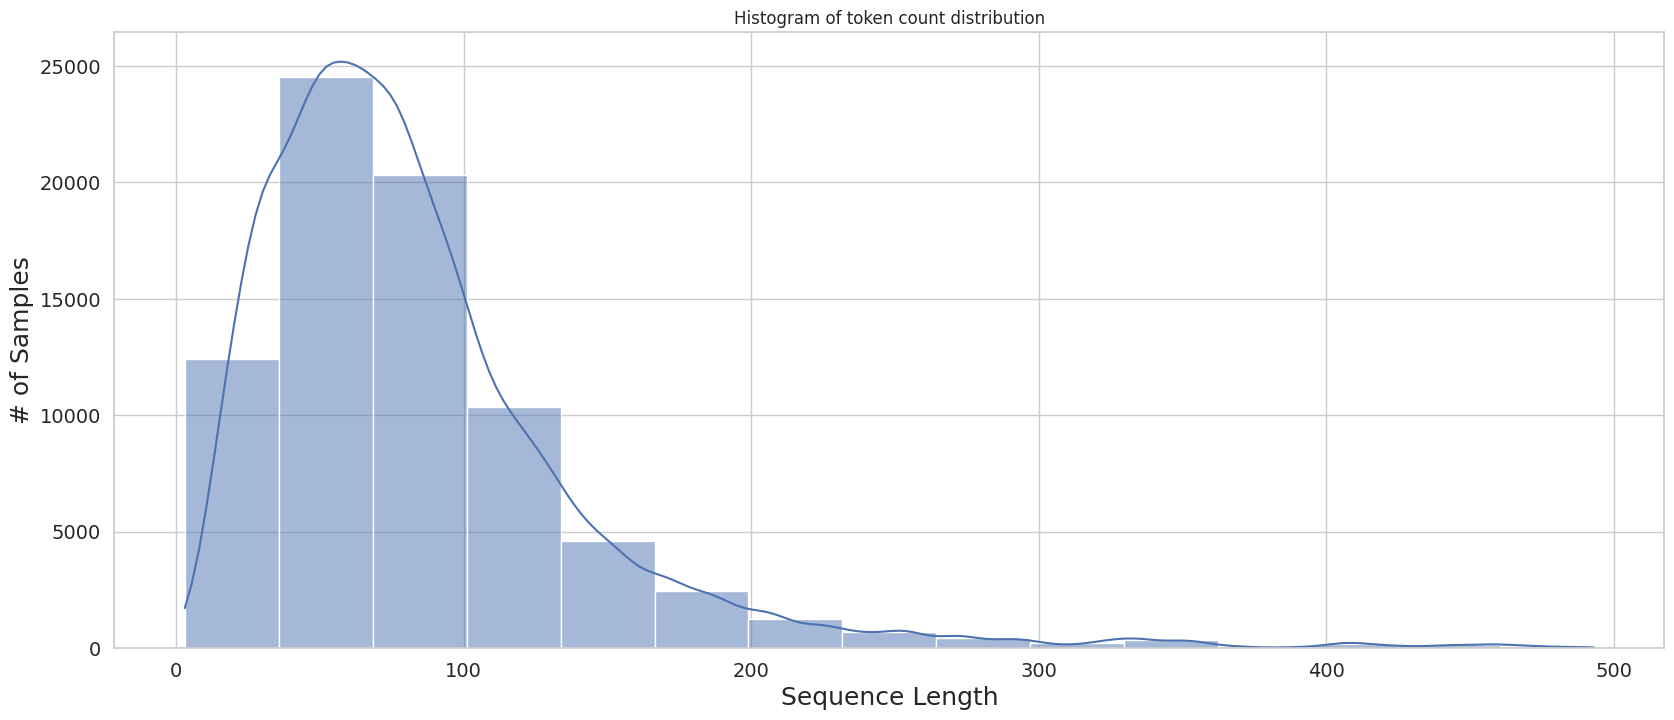

In [26]:
# token count distribution plot -- histogram

plt.figure(figsize=(20, 8))
sns.histplot(df_topic['token_count_message'], bins=15,kde=True).set_title('Histogram of token count distribution')
plt.xlabel('Sequence Length', fontsize = 18)
plt.ylabel('# of Samples', fontsize = 18)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.show();

Summary:
* The max sequence length is 493 so using the standard 512 seq length max will suffice.

In [27]:
from transformers import pipeline

## load model from HF
detect_model = pipeline(
    'text-classification',
    model="papluca/xlm-roberta-base-language-detection",
    truncation=True,
    max_length=512
)


config.json:   0%|          | 0.00/1.42k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

Device set to use cuda:0


## Detect Language 
* We define a `safe_text` function that converts NaN values to empty strings and ensures all other values are strings.
* We apply this function to the 'message' column before converting it to a list.
* This ensures that all_text contains only strings, which the model can process.
* By handling the NaN values and ensuring all inputs are strings, we can avoid a ValueError.



In [28]:
%%time
from tqdm import tqdm
tqdm.pandas() # load tqdm for pandas

# Function to safely process text with nan values
def safe_text(text):
    if pd.isna(text):
        return ""  # Return empty string for NaN values
    return str(text)  # Ensure all non-NaN values are strings

# Apply safe_text function to your column with progress bar
df_topic['processed_message'] = df_topic['message'].progress_apply(safe_text)

# Function to process batches
def process_batch(texts):
    results = detect_model(texts.tolist(), batch_size=32)
    return [d['label'] for d in results]

# Process in batches with a progress bar
batch_size = 1000  # Adjust this based on memory constraints
num_batches = len(df_topic) // batch_size + (1 if len(df_topic) % batch_size != 0 else 0)



language_labels = [] ## store labels in list
for i in tqdm(range(num_batches), desc="Processing batches"):
    start_idx = i * batch_size
    end_idx = min((i + 1) * batch_size, len(df_topic))
    batch_texts = df_topic['processed_message'].iloc[start_idx:end_idx]
    language_labels.extend(process_batch(batch_texts))

# Assign labels to DataFrame
df_topic['language_label'] = language_labels

# Print head
print(df_topic.head())

Processing batches: 100%|██████████| 79/79 [01:33<00:00,  1.18s/it]


     rec_id   nom_id   award_id      ah_id  link_id   group_id  award_private  \
0   8233964  8234230  183347810  180686706      NaN  155345180              0   
1  27259573  8234230  183349709  180686745      NaN  155346385              0   
2   8234900  8234230  183346874  180686686      NaN  155344570              0   
3  17519186  8234161  180137859  180686680      NaN  152736571              0   
4   9943897  8234230  183351071  180686682      NaN  155347328              0   

   product_id award_type          award_reason  \
0         620  Applaud 2        Make an Impact   
1         620  Applaud 2  Lead with Innovation   
2         620  Applaud 2        Take Ownership   
3         620  Applaud 2        Take Ownership   
4         620  Applaud 2        Make an Impact   

                                          title  \
0             Delivering Solid presales support   
1  Strong leader that also contributes in field   
2                     Executing with excellence   
3       

In [29]:
## view language label counts
df_topic['language_label'].value_counts().reset_index()

,language_label,count
0,en,77714
1,fr,173
2,de,90
3,ur,49
4,es,27
5,ja,17
6,bg,11
7,it,8
8,nl,6
9,pt,5


In [30]:
## sum languages
df_topic['language_label'].value_counts().sum()

78110

In [31]:
## len df_topic
len(df_topic)

78110

## Non-english text -- check outputs
* Lets check some of the outputs of the detected languages.

In [32]:
## german -- de
germ_rows = df_topic[df_topic['language_label'] == 'de'] 

## print german text
print('German Text identified:')
for i, row in germ_rows.iterrows(): 
    print(f"-{row['message']}")
    if i == 2: 
        break 

German Text identified:
-Hallo Thomas,  vielen Dank für deine Unterstützung dieses Jahr. Ich weiß, dass es nicht immer ganz einfach mit mir war, da mich dieses Jahr einige Themen abseits der Arbeit beschäftigt haben. Und auch das eine oder andere in der Arbeit. Trotzdem glaube ich hatten wir einige sehr gute Kundendiskussionen, die der Firma weitere Aufträge erbracht haben oder auch noch werden.  Erst mal Frohe Weihnachten dir und deiner Familie und auf die Zusammenarbeit in 2025.
-Lieber Serjoscha, du packst ordentlich mit an, wenn es von Nöten ist. Durch deine tatkräftige Mithilfe geht der Umzug unseres Düsseldorfer Büros schneller und reibungsloser von Statten. Danke, dass du Lisa, Teo und Maren so bereitwillig mit deiner Kraft unterstützt,
-Lieber Serjoscha,  vielen Dank für deine tolle Unterstützung bei dem Umzug im Büro!  Du hast kräftig mit angepackt und wir sind dank dir, definitiv schneller voran gekommen. Vielen Dank für deinen Einsatz!
-Lieber Lukas, ich möchte mich bei dir 

In [41]:
## Urdu - ur 
urdu_rows = df_topic[df_topic['language_label'] == 'ur'] 

## print urdu text
print('Urdu Text identified:')
for i, row in urdu_rows.iterrows(): 
    print(f"-{row['message']}")
    if i == 5: 
        break 

Urdu Text identified:
-Qlik Legends 12
-Q4 SPIFF AWARD
-Q4 SPIFF AWARD
-Q4 SPIFF AWARD
-Q4 SPIFF AWARD
-Q4 SPIFF
-Q4 SPIFF
-Q4 SPIFF
-Q4 SPIFF
-Q4 SPIFF AWARD
-Q4 SPIFF
-Q4 SPIFF
-Q4 SPIFF AWARD
-Q4 SPIFF
-Q4 SPIFF AWARD
-Q4 SPIFF
-Q4 SPIFF AWARD
-Q4 SPIFF
-Q4 SPIFF AWARD
-Q4 SPIFF AWARD
-Q4 SPIFF AWARD
-Q4 SPIFF AWARD
-Q4 SPIFF AWARD
-Q4 SPIFF AWARD
-Q4 SPIFF AWARD
-Q4 SPIFF
-Q4 SPIFF
-Q4 SPIFF
-Q4 SPIFF
-Q4 SPIFF AWARD
-Q4 SPIFF
-Q4 SPIFF
-Q4 SPIFF AWARD
-Q4 SPIFF
-Q4 SPIFF
-Q4 SPIFF
-Q4 SPIFF
-Q4 SPIFF
-Q4 SPIFF
-Q4 SPIFF
-Q4 SPIFF
-Q4 SPIFF
-Q4 SPIFF
-Q4 SPIFF
-Q4 SPIFF
-Happy Anniversary Ee Xin
-Qlik WIT IWD Quiz Winner
-Qlik WIT IWD Quiz Winner
-Qlik WIT IWD Quiz Winner


Summary
* Obviously this is not urdu text. However, the client doesnt care about the breakdown by language so in the end not a big deal. The topic model will still translate it. 

In [33]:
## polish -- pl
polish_rows = df_topic[df_topic['language_label'] == 'pl'] 

## print polish text
print('Polish Text identified:')
for i, row in polish_rows.iterrows(): 
    print(f"-{row['message']}")
    if i == 2: 
        break 

Polish Text identified:
-SS Bulldozya 3rd place. 
-SS Bulldozya 3rd place.


Summary
* This is actually english. Again not a big deal but good thing we took a look at what the model missed. 

In [34]:
## japanese -- ja
japan_rows = df_topic[df_topic['language_label'] == 'ja'] 

## print japanese text
print('Japanese Text identified:')
for i, row in japan_rows.iterrows(): 
    print(f"-{row['message']}")
    if i == 2: 
        break 

Japanese Text identified:
-いつもサポートして頂きありがとうございます。 日々サポートして頂いているお陰で営業に集中できております。 引き続きご支援よろしくお願いいたします。
-いつもQlikのためにありがとうございます。
-いつもありがとうございます！
-Thank you for always supporting us, I am really happy to have you in Tokyo team! 5年記念おめでとうございます！！
-３０周年パーティの企画や準備ありがとうございました。私も手伝おうと思っていたのですが、何もできずすみません(´;ω;｀)
-３０周年パーティの企画や準備ありがとうございました。私も手伝おうと思っていたのですが、何もできずすみません(´;ω;｀)
-APIのケース、プロキシ関連のケース、他にもたくさんのケースで的確なアドバイスをいただきありがとうございます。検証のアシストだけでなく、なぜこうなるのかの補足説明までいただけて、とても有り難く思っています。
-３月４月は大変でしたが、たくさん助けていただきありがとうございました。
-３月４月は大変でしたが、たくさん助けていただきありがとうございました。
-Xmas Partyでは寿司職人として皆さんにおいしいお寿司をふるまっていただきありがとうございました！
-Xmas Partyでは素晴らしいパフォーマンスを披露していただきありがとうございました！
-今年は１年お世話になりました。わからないことがあるとどんなケースでも聞いてしまいましたが、全て真摯に対応してくださったおかげでケースを進めることができました。ありがとうございました！良いお年を～！
-it was a really long long journey...７月から始まったので約半年間、お付き合いいただきありがとうございました！！！
-いつも笑顔でお話を聞いてくださったりケースをたくさん振ってくださったり、メンタル面でも技術面でも今年一年たくさんお世話になりました。仕事ができなすぎて落ち込むことが多い１年でしたが、Ayakaさんの温かさにたくさん救われました。Ayakaさんが私のマネージャーでよかったです。
-LCでCSの内容が多く来ていたときに、カジュアルにミーティングで１から丁寧に教

Summary
* This is japanese that was detected.

# Qwen/Qwen2.5-7B-Instruct
* This is the model we will use: https://huggingface.co/Qwen/Qwen2.5-7B-Instruct
* The other reasons to use Qwen-2.5?

1. Long-context Support up to 128K tokens and can generate up to 8K tokens.

2. Multilingual support for over 29 languages, including Chinese, English, French, Spanish, Portuguese, German, Italian, Russian, Japanese, Korean, Vietnamese, Thai, Arabic, and more. Thus we can use this for language translation tasks as part of our pipeline.

## Why use an Instruct model?
* The key difference between "Qwen2.5-7B" and "Qwen2.5-7B Instruct" is that the "Instruct" version is specifically fine-tuned to better follow instructions and generate text responses that are more aligned with user prompts, making it more suitable for direct interaction through conversational tasks, while the standard "Qwen2.5-7B" model serves as a more general-purpose foundation for further customization and fine-tuning by developers.

## Why are we using a 7B model and not the largest 72B model?
* According to the BERTopic inventor, Maarten says this is a "nice balance between inference and speed, accuracy and speed."
* A larger model would be more accurate but compute power would be an issue.
* A smaller model would be faster but less accurate.
* Thus we will take Maarten's advice and go with the "in-between" size.
* Previously I have used Llama-2 13B size following this same method and it worked quite well.

In [35]:
# import torch -- if not already done above
#import torch


## model_id
model_id = 'Qwen/Qwen2.5-7B-Instruct'

## device agnostic code
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# print device
print(device)

cuda


# QLoRA - LLM Optimization & Quantization
* Before we load a 14 BILLION PARAMETER LLM, optimization is a must!
* VRAM on any device is limited, so we need to condense the model to run it locally.
* There are numerous techniques and tricks to do this but the main principle is 4-bit quantization.
* This will reduce the 64-bit representation to only 4-bits which reduces the GPU memory needed to run the LLM model.

## QLoRA quantiation parameters we are using
1. **load_in_4bit**
    * Allows us to load the model in 4-bit precision compared to the original 32-bit precision. This gives us an incredible speed up and reduces memory!

2. **bnb_4bit_quant_type**
    * This is the type of 4-bit precision.
    * The original paper recommends normalized float 4-bit, so that is what we are going to use!

3. **bnb_4bit_use_double_quant**
    * This is a neat trick as it performs a second quantization after the first which further reduces the necessary bits

4. **bnb_4bit_compute_dtype**
    * The compute type used during computation, which further speeds up the model.

In [36]:
from torch import bfloat16 ## google brain float16 
import transformers

## now we set the quantization to load LLM with less GPU memory
## this requires the `bitsandbytes` library

##bits and bytes config -- 32 bit to 4 bit
bnb_config = transformers.BitsAndBytesConfig(
    load_in_4bit=True, #4-bit quantization
    bnb_4bit_quant_type='nf4', #normalized float 4
    bnb_4bit_use_double_quant=True, #second quantization after first
    bnb_4bit_compute_dtype=bfloat16 #computation type

)

## Load Qwen LLM Model from Hugging Face

In [37]:
# Load dependencies from hf
from transformers import AutoTokenizer, AutoModelForCausalLM
import accelerate

## load tokenizer
tokenizer = transformers.AutoTokenizer.from_pretrained(model_id)

## Qwen2.5-14B Instruct -- init model
model = transformers.AutoModelForCausalLM.from_pretrained(
    model_id,
    trust_remote_code=True,
    quantization_config=bnb_config, #quantization config from above
    device_map='auto' ## if you are distributing across GPUs
)

## model params
model.eval()

tokenizer_config.json:   0%|          | 0.00/7.30k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/2.78M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.67M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/7.03M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/663 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/27.8k [00:00<?, ?B/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/3.95G [00:00<?, ?B/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/3.86G [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/3.86G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/3.56G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/243 [00:00<?, ?B/s]

Qwen2ForCausalLM(
  (model): Qwen2Model(
    (embed_tokens): Embedding(152064, 3584)
    (layers): ModuleList(
      (0-27): 28 x Qwen2DecoderLayer(
        (self_attn): Qwen2Attention(
          (q_proj): Linear4bit(in_features=3584, out_features=3584, bias=True)
          (k_proj): Linear4bit(in_features=3584, out_features=512, bias=True)
          (v_proj): Linear4bit(in_features=3584, out_features=512, bias=True)
          (o_proj): Linear4bit(in_features=3584, out_features=3584, bias=False)
        )
        (mlp): Qwen2MLP(
          (gate_proj): Linear4bit(in_features=3584, out_features=18944, bias=False)
          (up_proj): Linear4bit(in_features=3584, out_features=18944, bias=False)
          (down_proj): Linear4bit(in_features=18944, out_features=3584, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): Qwen2RMSNorm((3584,), eps=1e-06)
        (post_attention_layernorm): Qwen2RMSNorm((3584,), eps=1e-06)
      )
    )
    (norm): Qwen2RMSNorm((3584,), 

## Setup DataParallel for multiple GPU support

In [ ]:
# import torch.nn as nn

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# if torch.cuda.device_count() > 1:
#     print(f"Using {torch.cuda.device_count()} GPUs!")
#     model = nn.DataParallel(model)
# else:
#     print("Using single GPU or CPU")

# # Unwrap the model from nn.DataParallel
# if isinstance(model, nn.DataParallel):
#     model = model.module

# model.to(device)

# Pipeline Setup
* Here we are going to setup a huggingface transformers pipeline for the LLM model.

* The specific task we want is `text-generation`.

* Penalty discourages repetitive or redundant output
    * It is designed to address the tendency of language models to produce repeated phrases, sentences, or patterns.
    * In topic modeling we generally DO NOT want repetitive outputs.
    * We also want to set the Temperature lower --> which is more deterministic.

* More about pipeline params: https://medium.com/@developer.yasir.pk/understanding-the-controllable-parameters-to-run-inference-your-large-language-model-30643bb46434

In [38]:
# Create the generator pipeline
generator = pipeline(
    task='text-generation',
    model=model,
    tokenizer=tokenizer,
    device=device.index if device.type == 'cuda' else -1,
    temperature=0.1,
    max_new_tokens=500,
    repetition_penalty=1.1
)



Device set to use cuda:0


# Prompt Engineering
* We can take the model for a "test drive" just to test that we are able to prompt the model and get a result.
* Then we can go into the specific prompt template we need to instruct the model to perform cross-lingual topic modeling.
* Since we are performing cross lingual topic modeling, I am going to ask the model to detect the language of the text I give to it and translate it to english as well as 1 or other languages. 

In [39]:
## test prompt
prompt_test_msg = """Lieber Serjoscha, du packst ordentlich mit an, wenn es von Nöten ist. 
Durch deine tatkräftige Mithilfe geht der Umzug unseres Düsseldorfer Büros schneller und reibungsloser von Statten. 
Danke, dass du Lisa, Teo und Maren so bereitwillig mit deiner Kraft unterstützt.
"""

prompt = f"Can you detect the language seen in this text: '{prompt_test_msg}', and state what language you detected and why you chose that language, then translate it to english, french, and italian?"
res = generator(prompt)
print(res[0]['generated_text'])

Can you detect the language seen in this text: 'Lieber Serjoscha, du packst ordentlich mit an, wenn es von Nöten ist. 
Durch deine tatkräftige Mithilfe geht der Umzug unseres Düsseldorfer Büros schneller und reibungsloser von Statten. 
Danke, dass du Lisa, Teo und Maren so bereitwillig mit deiner Kraft unterstützt.
', and state what language you detected and why you chose that language, then translate it to english, french, and italian? The language of the given text is German.

I identified this as German based on several key indicators:
1. Use of German-specific characters like ä (in "Serjoscha" and "Reibungslos").
2. Common German words such as "du", "wenn", "von", "Statten".
3. Sentence structure typical of German grammar.

Here are the translations into English, French, and Italian:

**English:** Dear Sergo, you're really pulling your weight when it's needed. Thanks for your active help which makes our Düsseldorf office move go faster and smoother. Thank you for supporting Lisa, T

# Setup Prompt Templates for Qwen-2-7B-Instruct
* In total we need 3 prompt templates that we will concatenate into a final prompt to use as input to topic model.
* The prompt templates for this model can be found here:
    * Qwen home page: https://qwenlm.github.io/resources/
    * Qwen huggingface repo: https://huggingface.co/Qwen/Qwen2.5-14B-Instruct

```
prompt = "Give me a short introduction to large language model."
messages = [
    {"role": "system", "content": "You are Qwen, created by Alibaba Cloud. You are a helpful assistant."},
    {"role": "user", "content": prompt}
]
```

## 1. System Prompt
* This is the first prompt needed. 

In [40]:
# system prompt describes information given to all conversations
system_prompt = """
<human>
You are a helpful, respectful, and honest assistant for labeling topics. 
You are skilled at analyzing text and identifying key themes and concepts.
</human>
"""

## Prompt Template we will use for topic modeling
* This is the recommended format for TOPIC MODELING. 
* There are two main components:
    * a. **example**
        * Most LLMs will do much better generating accurate responses if you give them examples to work from. Therefore we need to show an example of what we want our output to be.
        * **A note about this prompt. It is better to keep it "general" and not specific to your domain or data because I have tried that before and the result creates hallucination issues for the LLM as it thinks it has to focus on the details of your prompt rather than performing topic modeling. Thus, the "boilerplate" prompt below which comes from the BERTopic Author Maarten G. is a great example to use and it works well.**
      
    * b. **main prompt**


## 2. example_prompt
* This is the 2nd prompt needed.
* The prompt structure is:
  
1. Give the example documents or text.
2. Give example keywords.
3. End by stating "please create a short label of this topic"
        

In [41]:
# Example prompt demonstrating the output we are looking for
example_prompt = """
I have a topic that contains the following documents:
- Traditional diets in most cultures were primarily plant-based with a little meat on top, but with the rise of industrial style meat production and factory farming, meat has become a staple food.
- Meat, but especially beef, is the word food in terms of emissions.
- Eating meat doesn't make you a bad person, not eating meat doesn't make you a good one.

The topic is described by the following keywords: 'meat, beef, eat, eating, emissions, steak, food, health, processed, chicken'.

Based on the information about the topic above, please create a short label of this topic. Make sure you to only return the label and nothing more.
[/INST] Environmental impacts of eating meat
"""

## 3. main_prompt
* This is the 3rd prompt needed.
* The main prompt contains documents and keywords.
* Note about the code below:
  * The `[Languages]` placeholder is for the column I created above which is `language_label`. The concept of adding this to the prompt is to feed the LLM the previously detected language as context.
 
* The main_prompt has spaces for us to insert what DOCUMENTS and KEYWORDS we want to use which will change as we perform TOPIC MODELING.
* There are two BERTopic-specific tags that are of interest, namely `[DOCUMENTS]` and `[KEYWORDS]`:
    * `[DOCUMENTS]` contain the top 5 most relevant documents to the topic.
    * `[KEYWORDS]` contain the top 10 most relevant keywords to the topic as generated through c-TF-IDF algorithm from BERTopic.
* This template will be completed according to each topic.

In [42]:
## main prompt with documents and keywords
main_prompt = """
<human>
Instructions: I have a topic that contains the following documents:
[Documents]

The topic is described by the following keywords: '[Keywords]'.

Based on the information about the topic above, please create a short label for this topic. Make sure to only return the label and nothing more.
</human>

<response>
[Label]
</response>
"""

## Final Prompt

In [43]:
# final prompt format
full_prompt = system_prompt + example_prompt + main_prompt 

# Additional Data Preprocessing
* Before we create embeddings we want to store the `message` column in a separate variable.

Here's a suggested approach:

1. Create a new dataframe or a copy of the original dataframe to work with during the embedding creation and topic modeling process. This new dataframe should have the same index as the original dataframe.

2. In the new dataframe, create a new column or columns to store the embeddings, leaving the original message column untouched.

3. Perform the topic modeling process using the embeddings column(s) in the new dataframe.

4. After the topic modeling is complete, create new columns in the new dataframe to store the generated topics, keywords, or any other relevant information.

5. Since the new dataframe has the same index as the original dataframe, you can easily merge or join the new dataframe (containing the embeddings, topics, and keywords) back to the original dataframe using the index.


In [44]:
## lets see the df_topic
df_topic.head()

,rec_id,nom_id,award_id,ah_id,link_id,group_id,award_private,product_id,award_type,award_reason,title,message,award_date,value,remaining_value,token_count_message,processed_message,language_label
0,8233964,8234230,183347810,180686706,NaN,155345180,0,620,Applaud 2,Make an Impact,Delivering Solid presales support,Kam Wei has been instrumental in helping to cl...,2025-01-01,115.0,115.0,160,Kam Wei has been instrumental in helping to cl...,en
1,27259573,8234230,183349709,180686745,NaN,155346385,0,620,Applaud 2,Lead with Innovation,Strong leader that also contributes in field,Sid is a rare Player-Coach that inspires his c...,2025-01-01,115.0,115.0,133,Sid is a rare Player-Coach that inspires his c...,en
2,8234900,8234230,183346874,180686686,NaN,155344570,0,620,Applaud 2,Take Ownership,Executing with excellence,"Myung Soo rejoined Qlik in August 2024, but qu...",2025-01-01,115.0,115.0,261,"Myung Soo rejoined Qlik in August 2024, but qu...",en
3,17519186,8234161,180137859,180686680,NaN,152736571,0,620,Applaud 2,Take Ownership,APAC Presales Superstar for November,"Congrats, Sean!",2025-01-01,110.5,110.5,8,"Congrats, Sean!",en
4,9943897,8234230,183351071,180686682,NaN,155347328,0,620,Applaud 2,Make an Impact,Awesome AE that always delivers,Thank you Jason for being persistent and consi...,2025-01-01,115.0,115.0,77,Thank you Jason for being persistent and consi...,en


In [45]:
## create copy of df_topic
df_work = df_topic.copy()
df_work.head()

,rec_id,nom_id,award_id,ah_id,link_id,group_id,award_private,product_id,award_type,award_reason,title,message,award_date,value,remaining_value,token_count_message,processed_message,language_label
0,8233964,8234230,183347810,180686706,NaN,155345180,0,620,Applaud 2,Make an Impact,Delivering Solid presales support,Kam Wei has been instrumental in helping to cl...,2025-01-01,115.0,115.0,160,Kam Wei has been instrumental in helping to cl...,en
1,27259573,8234230,183349709,180686745,NaN,155346385,0,620,Applaud 2,Lead with Innovation,Strong leader that also contributes in field,Sid is a rare Player-Coach that inspires his c...,2025-01-01,115.0,115.0,133,Sid is a rare Player-Coach that inspires his c...,en
2,8234900,8234230,183346874,180686686,NaN,155344570,0,620,Applaud 2,Take Ownership,Executing with excellence,"Myung Soo rejoined Qlik in August 2024, but qu...",2025-01-01,115.0,115.0,261,"Myung Soo rejoined Qlik in August 2024, but qu...",en
3,17519186,8234161,180137859,180686680,NaN,152736571,0,620,Applaud 2,Take Ownership,APAC Presales Superstar for November,"Congrats, Sean!",2025-01-01,110.5,110.5,8,"Congrats, Sean!",en
4,9943897,8234230,183351071,180686682,NaN,155347328,0,620,Applaud 2,Make an Impact,Awesome AE that always delivers,Thank you Jason for being persistent and consi...,2025-01-01,115.0,115.0,77,Thank you Jason for being persistent and consi...,en


# Language Validation and Translation
* We can use the LLM to validate the `language_label` that we detected and also translate the `message` column to english prior to topic modeling.
* This would take away the need to have the LLM perform BOTH Topic Modeling and Translation all at the same time as it could prevent context window issues having it try and do too much at the same time.
* Also, if we can take advantage of the LLM as a seperate language validation and translation machine that would be most ideal. 

## LLM Translation to English
* We will translate the messages that were not labeled as "en" by xlm-roberta model. 
* We can now use the LLM Qwen-2.5-14B to translate the text to English.
* This is obviously the most crucial step in the pipeline as we want all non-english text to be english for topic modeling and presentation to the final stakeholders.

In [46]:
print(f"Current device of the model: {next(model.parameters()).device}")

Current device of the model: cuda:0


**Code below is an alternative approach to translation assuming you already ran the code above to verify the language detection.**
    * In this case I am bypassing this and going to the block below it which will translate all messages to english and also verify if the detection was correct with `xlm-roberta`.

## Language Translation using compute optimization 
* To improve compute efficiency in SageMaker, especially when dealing with a large number of rows (in our case more than 19,000), we can implement several optimizations.
* Here are some strategies to make the code run faster:

1. Batch Processing
   * Instead of processing one row at a time, we can batch the translations.
   * This reduces the number of API calls to hugging face hub and can significantly speed up the process.

2. Multiprocessing
    * Utilize multiple cores to process data in parallel.
    * Below the ProcessPoolExecutor is used to parallelize the processing across multiple CPU cores.

3. Caching
    * Store translations to avoid repeating work for duplicate messages.
    * Below the `lru_cache` decorator is used to cache translation results, avoiding redundant translations for repeated text.

4. Use a more efficient language detection method
    * If possible, use a faster language detection library like langdetect instead of relying solely on the existing labels.
    * Efficient Language Detection: langdetect is used for faster initial language detection as a verification step.
  
### DataParallel in PyTorch
* I am using multiple GPUs to work with a higher VRAM for using Qwen2.5.
* Here's a blog post explaining how much VRAM you need to run the Qwen models: https://simonwillison.net/2025/Jan/26/qwen25-1m/
  * VRAM Requirement for processing 1 million-token sequences:
```
1. Qwen2.5-7B-Instruct-1M: At least 120GB VRAM (total across GPUs).

2.Qwen2.5-14B-Instruct-1M: At least 320GB VRAM (total across GPUs).
```
### 3 ways to run model on multiple GPUs
1. Use nn.DataParallel or nn.parallel.DistributedDataParallel
   * Instead of relying on the automatic device mapping, you can manually wrap your model with nn.DataParallel or nn.parallel.DistributedDataParallel to ensure that the input tensors are properly distributed across the available GPUs.
import torch.nn as nn
```
if torch.cuda.device_count() > 1:
    model = nn.DataParallel(model)
```
2. Accelerate library
   * The Accelerate library, which is used by the Transformers library, provides a convenient way to handle multi-GPU setups. You can use the accelerate.initialize() function to set up the appropriate device mapping for your model.
```
from accelerate import Accelerator

accelerator = Accelerator()
model, tokenizer, device = accelerator.prepare(model, tokenizer, device)
```
3. Manually place the input tensors on the same device as the model
   * Before passing the input tensors to the model.generate() function, you can manually move the tensors to the same device as the model.
```
inputs = tokenizer(prompts, return_tensors="pt", padding=True, truncation=True, max_length=512)
inputs = {k: v.to(device) for k, v in inputs.items()}

with torch.no_grad():
    outputs = model.generate(**inputs, max_new_tokens=256)
```


## Language Translation - Simple Approach
* The final result of this code below will be `df_work_with_translation`, which will have the original `df_work` with the 'english_message' column populated for all rows, either by translation or by copying the original 'message' text.

* This approach is simpler and more straightforward than the previous multi-GPU implementation. The purpose of the multi-GPU implementation idea above is if you wanted to translate the ENTIRE DATAFRAME meaning checking the "en" language detected as well. But in this case we don't need to do that. 

In [57]:
# %%capture
# !pip install langdetect

In [47]:
## 1. Split the df_work into a smaller df based on the "language_label" column that is every language != 'en':
translate_df = df_work[df_work['language_label'] != 'en'].copy()
translate_df.head()

,rec_id,nom_id,award_id,ah_id,link_id,group_id,award_private,product_id,award_type,award_reason,title,message,award_date,value,remaining_value,token_count_message,processed_message,language_label
521,17324976,8759360,182661186,180359460,NaN,154837097,0,620,Cheer2,Succeed Together,Presales support in 2024,"Hallo Thomas, vielen Dank für deine Unterstüt...",2024-12-28,46.5,46.5,95,"Hallo Thomas, vielen Dank für deine Unterstüt...",de
1204,28141183,15924873,182674753,179882789,NaN,154847173,1,620,Cheer2,Take Ownership,Thank you for all your support!,"Thanks, Hashimoto-san!!",2024-12-23,56.5,56.5,9,"Thanks, Hashimoto-san!!",hi
1205,22521517,28355278,181495399,179882761,NaN,153879586,0,620,Cheer2,Succeed Together,Thank you for your suoorit,いつもサポートして頂きありがとうございます。 日々サポートして頂いているお陰で営業に集中でき...,2024-12-23,56.5,56.5,30,いつもサポートして頂きありがとうございます。 日々サポートして頂いているお陰で営業に集中でき...,ja
1471,8233311,28141193,182376624,179718310,NaN,154605162,0,620,Cheer2,Make an Impact,Muchas gracias por tu dedicación,Te lo mereces en un año especialmente complica...,2024-12-20,46.5,0.0,43,Te lo mereces en un año especialmente complica...,es
1472,27259398,28141193,182377405,179718249,NaN,154605860,0,620,Cheer2,Make an Impact,Bienvenido al equipo de Iberia!,Muchas gracias por tu ayuda en promocionar nue...,2024-12-20,46.5,46.5,35,Muchas gracias por tu ayuda en promocionar nue...,es


In [48]:
## check languagel labels
translate_df['language_label'].value_counts()

language_label
fr    173
de     90
ur     49
es     27
ja     17
bg     11
it      8
nl      6
pt      5
hi      4
sw      2
tr      2
pl      2
Name: count, dtype: int64

Summary
* No english labels, great now lets translate these non-english labels to english.

In [51]:
## 2. Translate the "message" column to English using the model and store the translations in a new column called 'english_message':
from transformers import pipeline
import torch
from tqdm import tqdm
import time

def prepare_prompt(text):
    return f"""<human>: You are a professional translator. Translate the following text to English. If the text is already in English, respond with 'ALREADY_ENGLISH'.

Text: {text}

Translate to English:</human>

<assistant>: Here's the English translation:

"""

def translate_text(text):
    prompt = prepare_prompt(text)
    inputs = tokenizer(prompt, return_tensors="pt", padding=True, truncation=True, max_length=512)
    input_ids = inputs.input_ids.to(device)
    attention_mask = inputs.attention_mask.to(device)
    
    with torch.no_grad():
        outputs = model.generate(input_ids, attention_mask=attention_mask, max_new_tokens=256)
    
    translation = tokenizer.decode(outputs[0], skip_special_tokens=True)
    translation = translation.split("<assistant>:")[-1].strip()
    return translation if translation.upper() != 'ALREADY_ENGLISH' else text

# Translate the messages in batches
batch_size = 8
start_time = time.time()
for i in tqdm(range(0, len(translate_df), batch_size), desc="Translating messages"):
    batch = translate_df['message'].iloc[i:i+batch_size]
    translate_df.loc[translate_df.index[i:i+batch_size], 'english_message'] = batch.apply(translate_text)
    
    # Clear CUDA cache after each batch
    torch.cuda.empty_cache()

## time of translation
end_time = time.time()
translation_time = end_time - start_time
print(f"Total translation time: {translation_time:.2f} seconds")

Translating messages: 100%|██████████| 50/50 [13:52<00:00, 16.65s/it]

Total translation time: 832.62 seconds


In [52]:
## 3. Join or merge the "translate_df" back to the original df_work, ensuring that all "language_label" that were "en" have the "message" text copied over to the new "english_message" column:
# Create a copy of the original df_work
df_work_with_translation = df_work.copy()

## 4. Update the 'english_message' column for rows where 'language_label' is 'en'
df_work_with_translation.loc[df_work['language_label'] == 'en', 'english_message'] = df_work['message']

# 5. Merge the translated df back into the original df_work
df_work_with_translation.update(translate_df[['english_message']])


In [59]:
## view result
df_work_with_translation.head()

,rec_id,nom_id,award_id,ah_id,link_id,group_id,award_private,product_id,award_type,award_reason,title,message,award_date,value,remaining_value,token_count_message,processed_message,language_label,english_message
0,8233964,8234230,183347810,180686706,NaN,155345180,0,620,Applaud 2,Make an Impact,Delivering Solid presales support,Kam Wei has been instrumental in helping to cl...,2025-01-01,115.0,115.0,160,Kam Wei has been instrumental in helping to cl...,en,Kam Wei has been instrumental in helping to cl...
1,27259573,8234230,183349709,180686745,NaN,155346385,0,620,Applaud 2,Lead with Innovation,Strong leader that also contributes in field,Sid is a rare Player-Coach that inspires his c...,2025-01-01,115.0,115.0,133,Sid is a rare Player-Coach that inspires his c...,en,Sid is a rare Player-Coach that inspires his c...
2,8234900,8234230,183346874,180686686,NaN,155344570,0,620,Applaud 2,Take Ownership,Executing with excellence,"Myung Soo rejoined Qlik in August 2024, but qu...",2025-01-01,115.0,115.0,261,"Myung Soo rejoined Qlik in August 2024, but qu...",en,"Myung Soo rejoined Qlik in August 2024, but qu..."
3,17519186,8234161,180137859,180686680,NaN,152736571,0,620,Applaud 2,Take Ownership,APAC Presales Superstar for November,"Congrats, Sean!",2025-01-01,110.5,110.5,8,"Congrats, Sean!",en,"Congrats, Sean!"
4,9943897,8234230,183351071,180686682,NaN,155347328,0,620,Applaud 2,Make an Impact,Awesome AE that always delivers,Thank you Jason for being persistent and consi...,2025-01-01,115.0,115.0,77,Thank you Jason for being persistent and consi...,en,Thank you Jason for being persistent and consi...


In [61]:
## len
len(df_work_with_translation)

78110

# BERTopic and Topic Modeling
* Now that the LLM is setup we can get into Topic Modeling.

## 1. Prepare Embeddings
    * Pre-calculation of embeddings for each document to speed-up additional exploration steps and use the embeddings to quickly iterate over BERTopic's hyperparameters as needed.

### Multilingual Embeddings
* I am going to use the LLM for cross-lingual topic modeling, thus as part of the pipeline I need to use embeddings.
* You can use ANY embedding model that you want to, here we will use a `SentenceTransformer implementation of an open source embedding model from Hugging Face. 
* However, because we are dealing with multilingual text, I am going to use a multilingual embedding model that has performed well on text clustering and classification tasks which is what we are trying to do.
* Embedding Model I am using: `BAAI/bge-m3`
    * Hugging Face Model card: https://huggingface.co/BAAI/bge-m3
    * This model is similar in its functionality to the Jina.ai model that I had originally wanted to use. 
    * 1) Handles long context windows up to 8192 tokens.
    * 2) Multilingual support
    * 3) Is able to handle 3 common retrieval functionalities of embedding models:
         * dense retrieval
         * multi-vector retrieval
         * sparse retrieval
     
### Wait...We just translated the text using Qwen LLM from non-english to english -- so do we need mutlilingual embeddings?
* Triple Bam! Great question! This is an important consideration when working with translated text and transformer models. Let's break down the scenario and discuss the implications:

1. **Translating to English**
   If you're using an LLM to translate all non-English text to English before passing it to your transformer model, you've effectively converted your dataset into a monolingual (English-only) dataset.

2. **Using a transformer model on translated text**
   Once all your text is in English, you're working with English language data, regardless of its original source language.

Given this scenario, here's what we should consider:

1. **English-only embeddings would be sufficient**
   - Since all your text is now in English, using English-only embeddings would be appropriate and potentially more efficient.
   - English-only models are often more refined for English language nuances, as they're trained on larger English corpora.

2. **Reasons we might still consider multilingual embeddings**
   - If you suspect that the translation process might introduce some non-English artifacts or structures.
   - If you want to capture potential cross-lingual semantic relationships that might persist even after translation.

3. **Potential drawbacks of using multilingual embeddings on translated text**
   - Unnecessary computational overhead, as you're using a more complex model than needed.
   - Potential dilution of English-specific features, as multilingual models balance their capacity across multiple languages.

4. **Important considerations**
   - Translation quality: The effectiveness of using English-only embeddings depends on the quality of your translations. High-quality translations would work well with English-only embeddings, while lower-quality translations might benefit from the robustness of multilingual embeddings.
   - Task specificity: Consider the specific requirements of your downstream task. Some tasks might be more sensitive to subtle linguistic differences that could be preserved in multilingual embeddings.

### Overall Recommendation
* Given that we are translating everything to English before processing, I would recommend starting with English-only embeddings. This approach will likely be more efficient and potentially more accurate for English text analysis.
* However, it would be valuable to experiment with both approaches (English-only and multilingual embeddings) and compare their performance on your specific task and dataset. This empirical comparison will give you the most definitive answer for your particular use case.
* It is also important to consider the impact of translation on the overall results, as some nuances or cultural context might be lost in translation, regardless of the embedding type you choose.
* Thus I will still proceed with the multilingual embedding model. 

In [62]:
%%capture
!pip install sentence-transformers

### Embedding Optimization
* To better optimize the embedding creation process and make better use of compute power I will do the following:
    * 1. Use a tqdm progress bar - The tqdm library is used to display a progress bar during the encoding process.
    * 2. Use the hugging face accelerate library -
        * This automatically handles cuda device placement, distributed training, and mixed precision.
        * The Accelerator class is used to prepare the model for acceleration and distribute the computation across multiple devices (if available).

    * 3. Use pandas cudflibrary from nvida (I was going to do this but not needed).
        * This library helps to optimize the efficiency of pandas dataframe processing.
        * It can be used in 2 ways, I will use this method: %load_ext cudf.pandas
        * Here is the repo for more information about this very popular library: GitHub - rapidsai/cudf: cuDF - GPU DataFrame Library

    * 4. Matryoshka representation (I was going to use this but this is a last resort). 


#### Embedding Optimization Workflow is as follows: 
* The workflow is as follows:
    * Initialize the Accelerator instance from the accelerate library.
    * Load specified sentence transformer model and prepares it for acceleration.
    * Iterate over the `message` column of the df_work DataFrame in batches of 64 using the tqdm progress bar.
    * Encode each batch of text using `embedding_model.encode` function.
    * Gather the results from all processes using `accelerator.gather`.
    * Finally, creates a new embeddings column in the `df_work` DataFrame with the computed embeddings.


* Overall, this workflow should significantly improve the efficiency of the embedding creation process by utilizing available hardware resources and distributing the computation across multiple devices (if available).


### Create Multilingual Embeddings
* The code below will clear the hugging face cache from Transformers library to better optimize memory.

In [63]:
# clear the Hugging Face cache in your current version of the Transformers library:
# Import the necessary modules:
from transformers import __file__ as transformers_path
from pathlib import Path
import shutil

## Find cache directory path:
# Get the path to the Transformers library
transformers_dir = Path(transformers_path).parent

# Construct the path to the cache directory
cache_dir = transformers_dir / "cached_path"

In [64]:
## print the cache_dir
print(cache_dir)

/usr/local/lib/python3.10/dist-packages/transformers/cached_path


In [65]:
## clear the cache
if cache_dir.exists(): 
    shutil.rmtree(cache_dir)

### Load Embedding Model from HuggingFace
* This is the model I am using: https://huggingface.co/BAAI/bge-m3

In [66]:
from sentence_transformers import SentenceTransformer
from accelerate import Accelerator

# Initialize the accelerator
accelerator = Accelerator()

# Set the model name/checkpoint
embedding_model_name = "BAAI/bge-m3"

# Load the model onto the appropriate device
embedding_model = SentenceTransformer(embedding_model_name, device=accelerator.device)
embedding_model = accelerator.prepare(embedding_model)

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/123 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/15.8k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/54.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/687 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/2.27G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/444 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.27G [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/964 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/191 [00:00<?, ?B/s]

**Code below creates the embeddings**

In [92]:
import pandas as pd
from tqdm import tqdm
from accelerate import Accelerator
import os

# Create embeddings in batches of the message column in the df_work dataframe
embeddings = []
batch_size = 64
bar_format = "{l_bar}{bar}| {n_fmt}/{total_fmt} [{elapsed}<{remaining}]"

# Create embeddings in batches
batches = [df_work_with_translation['english_message'].values[i:i + batch_size].tolist() for i in range(0, len(df_work_with_translation), batch_size)]

for batch in tqdm(batches, disable=not accelerator.is_main_process, bar_format=bar_format):
    batch_embeddings = embedding_model.encode(batch, show_progress_bar=False, convert_to_tensor=True)
    # Ensure the batch_embeddings is 2-dimensional
    if batch_embeddings.dim() == 1:
        batch_embeddings = batch_embeddings.unsqueeze(0)
    embeddings.append(batch_embeddings.cpu().numpy().tolist())

# Concatenate the embeddings into a single list
embeddings = [emb for batch_embeddings in embeddings for emb in batch_embeddings]

# Add the embeddings to the dataframe
df_work_with_translation['embeddings'] = embeddings

# Save the entire dataframe to a Parquet file
df_work_with_translation.to_parquet('df_with_embeddings.parquet')

print("Dataframe with embeddings saved to Parquet file successfully.")

100%|██████████| 1221/1221 [03:30<00:00]


Dataframe with embeddings saved to Parquet file successfully.


In [68]:
# # Create embeddings in batches of the message column in the df_work dataframe
# embeddings = []
# batch_size = 64
# bar_format = "{l_bar}{bar}| {n_fmt}/{total_fmt} [{elapsed}<{remaining}]"

# # Create embeddings in batches
# batches = [df_work_with_translation['english_message'].values[i:i + batch_size].tolist() for i in range(0, len(df_work_with_translation), batch_size)]

# for batch in tqdm(batches, disable=not accelerator.is_main_process, bar_format=bar_format):
#     batch_embeddings = embedding_model.encode(batch, show_progress_bar=False, convert_to_tensor=True)
#     # Ensure the batch_embeddings is 2-dimensional
#     if batch_embeddings.dim() == 1:
#         batch_embeddings = batch_embeddings.unsqueeze(0)
#     embeddings.append(batch_embeddings)

# # Gather the results from all processes
# embeddings = accelerator.gather(torch.cat(embeddings, dim=0))

# # Convert the embeddings to a pandas Series
# if accelerator.is_main_process:
#     df_work_with_translation['embeddings'] = pd.Series(embeddings.cpu().numpy().tolist())

# print("Embeddings added to dataframe successfully.")

100%|██████████| 1221/1221 [03:12<00:00]


Embeddings added to dataframe successfully.
